# Asymmetric migration

# Background

# Simulations

## Imports / Configuration

Import standand libraries as well as some scripts in `../scripts` that have defined helper function to setup the habitat and simulate data under the coalescent given a habitat

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv
import pickle as pkl
import os

# import helper functions for this notebook see ../scripts
import sys
sys.path.append('../scripts/')
from define_habitat import gen_lattice, quadratic_barrier_weights, asymetric_uniform_migration
from simulate_genotypes import stepping_stone

In [2]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

## Helper functions

In [3]:
def node_to_obs_mat(x, n, v):
    '''
    Converts node level array to data level array
    
    Args:
        x: np.array
            array at the level of nodes
        n: int
            number of observations
        v: np.array
            array carraying the node ids for each
            observation
    Returns:
        y: np.array
            array at the level of observations repeated
            from the node level array
    '''
    y = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y[i,j] = x[v[i], v[j]]
            
    return(y)

def cov_to_dist(sigma):
    '''
    Converts covariance matrix to distance matrix
    
    Args:
        sigma: np.array
            covariance matrix
    Returns:
        d: np.array
            distance matrix
    '''
    n = sigma.shape[0]
    ones = np.ones(n).reshape(n, 1)
    sigma_diag = np.diag(sigma).reshape(n, 1)
    d = ones.dot(sigma_diag.T) + sigma_diag.dot(ones.T) - (2. * sigma)

    return(d)

## Setup up the habitat

In [33]:
n = 8 # number of rows in lattice
p = 8 # number of cols in lattice
d = n * p # number of demes
lattice_dict = gen_lattice(n, p)
g = lattice_dict['g'].to_directed() # the graph obj
s = lattice_dict['s'] # spatial positions
v = lattice_dict['v'] # node ids
pos_dict = lattice_dict['pos_dict']

for i,j in g.edges():
    if i < j:
        g[i][j]['m'] = .1
    else:
        g[i][j]['m'] = 0.0

#g = asymetric_uniform_migration(g, .1).to_directed()
weights = [g[i][j]['m'] for i,j in g.edges() if g[i][j]['m'] != 0.0]
edges = [(i,j) for i,j in g.edges() if g[i][j]['m'] != 0.0]

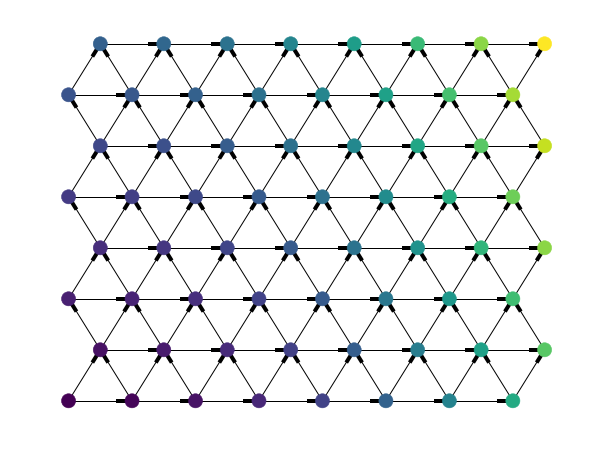

In [40]:
nx.draw(g, pos=pos_dict, node_size=200, node_color=s[:,0]**2 + (np.sqrt(d) / 2) * s[:,1], 
        cmap=cm.viridis, arrows=True, edgelist=edges, width=10*np.array(weights))  

In [41]:
m = nx.adjacency_matrix(g, weight='m')
m = m.toarray()
d = m.shape[0]

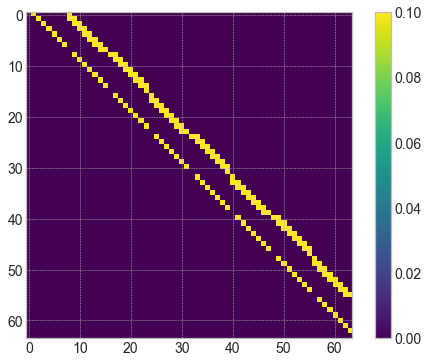

In [42]:
plt.imshow(m, cmap=cm.viridis)
plt.colorbar()

In [43]:
%%time
path = '../output/y_asym_unif_stepping_stone.pkl'
if os.path.exists(path):
    with open(path, 'rb') as geno:
        y = pkl.load(geno)
else:
    with open(path, 'wb') as geno:
        y = stepping_stone(m, n_rep=5000, n=10)
        pkl.dump(y, geno)

extracting tree 0
extracting tree 250
extracting tree 500
extracting tree 750
extracting tree 1000
extracting tree 1250
extracting tree 1500
extracting tree 1750
extracting tree 2000
extracting tree 2250
extracting tree 2500
extracting tree 2750
extracting tree 3000
extracting tree 3250
extracting tree 3500
extracting tree 3750
extracting tree 4000
extracting tree 4250
extracting tree 4500
extracting tree 4750
CPU times: user 1min 24s, sys: 1.24 s, total: 1min 25s
Wall time: 1min 28s


In [44]:
# number simulated of haploid individuals and snps
n, p = y.shape 
print(n, p)

640 8728


In [45]:
v_obs = np.repeat(v, int(n / d)).T
s_obs = np.vstack([np.repeat(s[:,0], int(n / d)), np.repeat(s[:,1], int(n / d))]).T
m_obs = node_to_obs_mat(m, n, v_obs)

Text(0,0.5,'log(Count)')

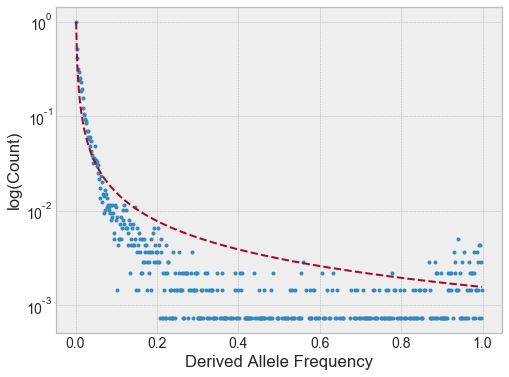

In [46]:
dac = np.sum(y, axis=0) 
x = np.arange(1, n) / n
sfs = np.histogram(dac, bins=np.arange(1, n + 1))[0]
plt.semilogy(x, sfs / sfs[0], '.')
plt.semilogy(x, 1 / (x * n), '--')
plt.xlabel('Derived Allele Frequency')
plt.ylabel('log(Count)')

In [47]:
fil_idx = np.where(((dac / n) >= .05) & ((dac / n) <= .95))[0]
y = y[:,fil_idx]
p = float(y.shape[1])
print(n, p)

640 1620.0


In [48]:
mu = np.mean(y, axis=0)
std = np.std(y, axis=0)
z = (y - mu) / std

Text(0,0.5,'PC2')

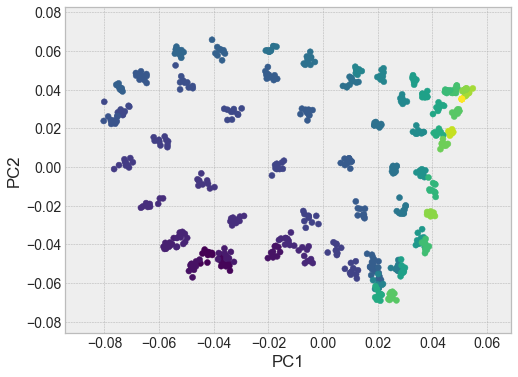

In [49]:
pca = PCA(n_components=5)
pca.fit(z.T)
pcs = pca.components_.T
plt.scatter(pcs[:,0], pcs[:,1], c=s_obs[:,0]**2 + (np.sqrt(d) / 2) * s_obs[:,1], cmap=cm.viridis)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [50]:
d_geno_obs = squareform(pdist((y - mu), metric='seuclidean')) / p
d_geo_obs = squareform(pdist(s_obs, metric='seuclidean')) / 2

In [51]:
l = np.diag(m.sum(axis=1)) - m

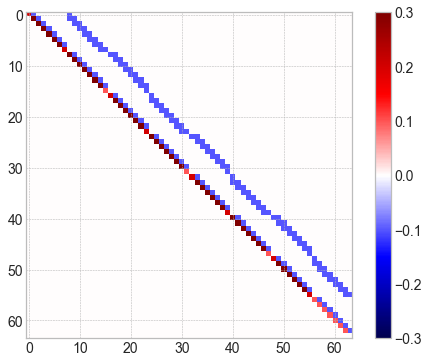

In [52]:
plt.imshow(l, cmap='seismic', norm=mpl.colors.Normalize(vmin=-np.max(l), vmax=np.max(l)))
plt.colorbar()

In [53]:
l_inv = pinv(l)
d_res = cov_to_dist(l_inv)
d_res_obs = node_to_obs_mat(d_res, n, v_obs)

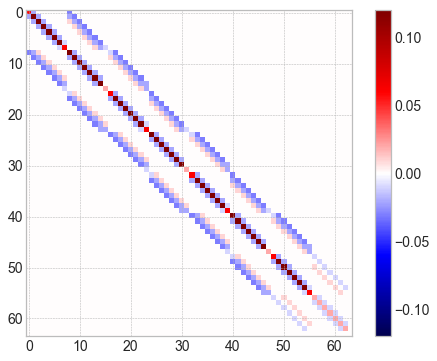

In [54]:
llt = l.dot(l.T)
plt.imshow(llt, cmap='seismic', norm=mpl.colors.Normalize(vmin=-np.max(llt), vmax=np.max(llt)))
plt.colorbar()

In [55]:
llt_inv = pinv(llt)
d_rw = cov_to_dist(llt_inv)
d_rw_obs = node_to_obs_mat(d_rw, n, v_obs)

In [56]:
tri_idx = np.tril_indices(n, -1) # extract only lower tri of distance matrix
dist_df = pd.DataFrame({'Geographic Distance': d_geo_obs[tri_idx], 
                        'Genetic Distance': d_geno_obs[tri_idx],
                        'Resistence Distance': d_res_obs[tri_idx],
                        'Random Walk Distance': d_rw_obs[tri_idx]
                       })


r2 = 0.6327563983384584


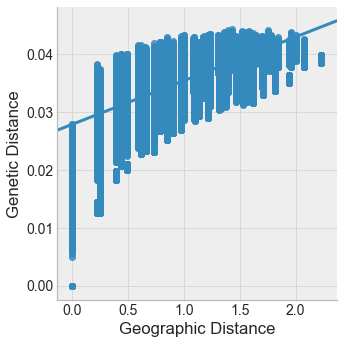

In [57]:
print('r2 = {}'.format(np.corrcoef(dist_df['Geographic Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Geographic Distance', y='Genetic Distance', data=dist_df)

r2 = 0.08168874371530356


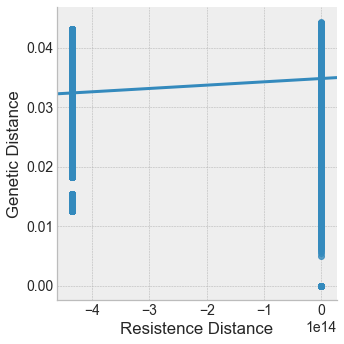

In [58]:
print('r2 = {}'.format(np.corrcoef(dist_df['Resistence Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Resistence Distance', y='Genetic Distance', data=dist_df)

r2 = -0.08973527883316779


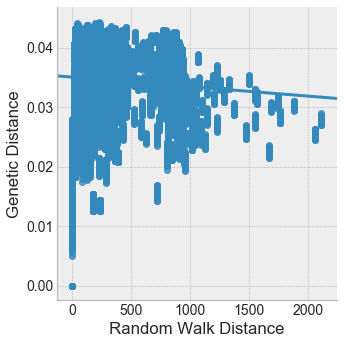

In [59]:
print('r2 = {}'.format(np.corrcoef(dist_df['Random Walk Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Random Walk Distance', y='Genetic Distance', data=dist_df)